In [1]:
import numpy as np
import os
import optparse
from scipy.stats import beta
import h5py
import sys
import ligo.skymap.plot
from ligo.skymap.io import read_sky_map
from ligo.skymap import postprocess
from matplotlib.colors import rgb2hex as rgb2hex
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
colors=sns.color_palette('colorblind')




In [3]:


s = 1000
f = open('../..//index.txt', 'r')
lines = f.readlines()
ra = []
dec = []
dl = []
os.system('mkdir tmp')

for i,line in enumerate(lines):
    if i == 68:# or (i>=66 and i<=68):
        print (line)
        os.system('rm -rf tmp/*')
        ra.append(float(line.split()[5]))
        dec.append(float(line.split()[7]))
        dl.append(float(line.split()[17]))
        data_source = str(i)+'/None_result.json'
        os.system('cp ' + data_source + ' tmp/.');
    
        make_h5_file = 'bilby_pipe_to_ligo_skymap_samples  tmp/None_result.json -o tmp/bilby_samples.hdf5'
        os.system(make_h5_file);
        f = h5py.File('tmp/bilby_samples.hdf5','a')
        samples= np.array([f['posterior_samples']['ra'],f['posterior_samples']['dec'],f['posterior_samples']['luminosity_distance']]).T                
        samples_new = samples[np.random.choice(np.arange(len(samples)),size=s,p=samples[:,2]**-1/np.sum(samples[:,2]**-1))]

        hf = h5py.File('tmp/bilby_samples1.hdf5','w')
        dtype = (np.record, [('ra', '<f8'), ('dec', '<f8'), ('luminosity_distance', '<f8')])
        samples = []
        for j in range(len(samples_new)):
            samples.append((samples_new[j,0],samples_new[j,1],samples_new[j,2]))                
        hf.create_dataset('posterior_samples',shape=(s,),dtype=dtype,data=samples)
        hf.close()
        
        os.system('ligo-skymap-from-samples -o tmp/. --maxpts '+str(s)+' tmp/bilby_samples1.hdf5');
        os.system('mv tmp/bilby_samples1.hdf5 '+str(i)+'/.')
        os.system('mv tmp/skymap.fits '+str(i)+'/.')
        os.system('rm tmp/*.json')
        os.system('rm tmp/*.hdf5')
#print (ra, dec)

    
    

mkdir: cannot create directory ‘tmp’: File exists


   --mass1 1.44   --mass2 1.4   --ra 3.534291735288517   --dec -0.7297276562269666   --theta_jn 1.0   --psi 1.5707963267948966   --phase 1.5707963267948966   --geocent_time 630696093        --luminosity_distance 28.402998455572302     --no_finite_size_ana       --sample rwalk_dynesty



15:21 bilby_pipe INFO    : Converting bilby result file tmp/None_result.json
15:21 bilby_pipe INFO    : The directory /nfshome/store04/users/pratyusava.baral/3g_PE/run_directory/snr1000.0/thetajn1.0/CE/results/68 is not accessible, falling back to the current working directory
15:21 bilby_pipe INFO    : Writing 18137 ligo-skymap ready samples to tmp/bilby_samples.hdf5
2023-04-29 15:22:03,801 INFO reading samples
2023-04-29 15:22:03,826 INFO clustering ...
100%|██████████| 200/200 [01:32<00:00,  2.16it/s]
2023-04-29 15:23:36,341 INFO clustering ...
100%|██████████| 200/200 [01:14<00:00,  2.70it/s]
2023-04-29 15:24:50,536 INFO pickling
2023-04-29 15:24:50,540 INFO making skymap


adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
evaluating distance layers ...


100%|██████████| 16896/16896 [00:14<00:00, 1181.34it/s]
2023-04-29 15:25:07,193 WARNING Cannot determine the event time from any of the columns ['time', 'time_mean', 'time_maxl']


In [22]:
def plot_skymap(file1, labels, label_rotations, events, ra, dec, dl, outname='skymap.pdf'):

    fig = plt.figure(figsize=(6, 3), dpi=300)
    ax = fig.add_subplot(111, projection='astro hours mollweide')
    #plt.plot(np.degrees(ra), np.degrees(dec), 'xk', markersize=5, transform = ax.get_transform("world"))
    ax.grid()
    
    center = SkyCoord(ra=ra * 180/np.pi *u.deg,
                        dec = dec * 180/np.pi * u.deg,
                        distance = dl * 1e6 * u.pc)
    
    ax_inset = plt.axes(
    [0.1, 0.6, 0.25, 0.25],
    projection='astro zoom',
    center=center,
    radius=7*u.deg)
    
    for i,event in enumerate(events):
        skymap1, _ = read_sky_map(file1[event])
        cfl1 = postprocess.find_greedy_credible_levels(skymap1)

        color={0:'k', 1: 'tab:blue', 2:'g',3:'tab:orange'}#rgb2hex(colors[colorn[i]])
        print (color[i])
        ax.contour_hpx(cfl1, linewidths=1.5, colors=color[i],linestyles='solid', levels=[0.9,])
        ax_inset.contour_hpx(cfl1, linewidths=1.5, colors=color[i],linestyles='solid', levels=[0.9,])
        plt.text(labels[event][0][0], labels[event][0][1], event, fontsize=10, color=color[i], rotation=label_rotations[event][0])
    for key in ['ra', 'dec']:
        ax_inset.coords[key].set_ticklabel_visible(False)
        ax_inset.coords[key].set_ticks_visible(False)
    
    ax.mark_inset_axes(ax_inset)
    ax.connect_inset_axes(ax_inset, 'lower left')
    ax.connect_inset_axes(ax_inset, 'lower right')
    ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
    #ax_inset.compass(0.9, 0.1, 0.2)  
    ax_inset.plot(center.ra.deg, center.dec.deg, transform=ax_inset.get_transform('world'), marker='x', markersize=5, color = 'r',markeredgewidth=3)
    plt.savefig(outname)

k
tab:blue


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


g
tab:orange


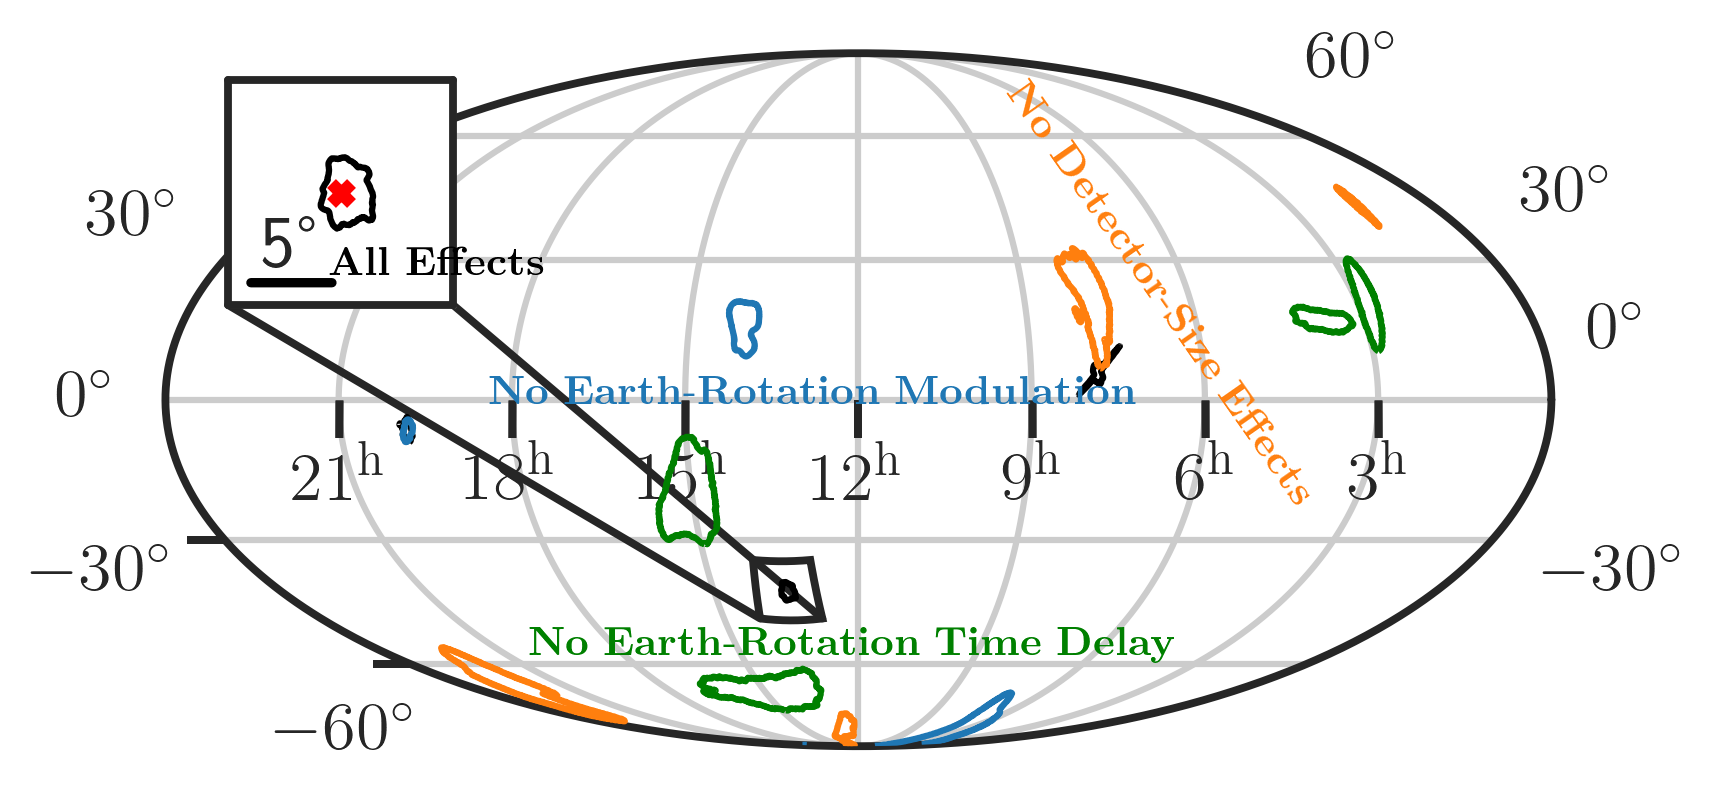

In [23]:
f = open('../..//index.txt', 'r')
line = f.readlines()[67]
ra = []
dec = []
dl = []
ra.append(float(line.split()[5]))
dec.append(float(line.split()[7]))
dl.append(float(line.split()[17]))


direc27 = '40/skymap.fits'
direc50 = '66/skymap.fits'
direc51 = '67/skymap.fits'
direc52 = '68/skymap.fits'

l1 = r'$\bf All ~ Effects$'
l2 = r'${\bf No ~ Earth}$-${\bf Rotation ~ Modulation}$'
l3 = r'${\bf No ~ Earth}$-${\bf Rotation~ Time ~ Delay}$'
l4 = r'${\bf No ~ Detector}$-${\bf Size ~ Effects}$'

file1 = {l1: direc27, l2: direc50, l3: direc51, l4: direc52}


#labels = {l1: [(100,30)], l2: [(1000, -200)], l3: [(180, -90)], l4: [(550, -100)]}

labels = {l1: [(100,30)], l2: [(260,-100)], l3: [(300, -350)], l4: [(770, -200)]}

label_rotations = {l1: [0], l2:[0], l3:[0], l4:[-55]}
        
events = [l1, l2, l3, l4]
plot_skymap(file1, labels, label_rotations, events, ra = ra[-1], dec = dec[-1], dl=dl[-1], outname='A_skymap3.pdf')
        #sys.exit()


In [21]:
import h5py
data = []
for i in [40,66,67,68]:
    f = h5py.File(str(i)+'/bilby_samples1.hdf5','r')
    data.append(np.array([f['posterior_samples']['ra'],f['posterior_samples']['dec'],f['posterior_samples']['luminosity_distance']]))

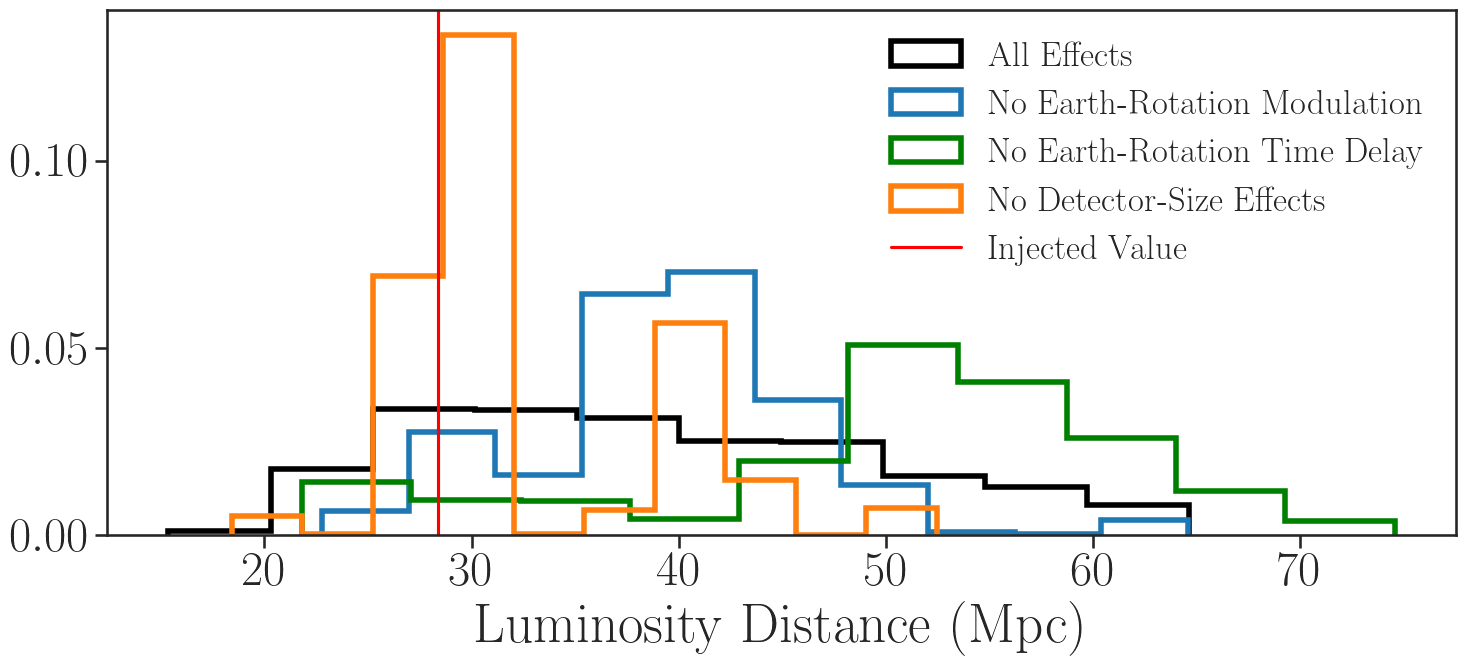

In [25]:
l1 = r'$\rm All ~ Effects$'
l2 = r'${\rm No ~ Earth}$-${\rm Rotation ~ Modulation}$'
l3 = r'${\rm No ~ Earth}$-${\rm Rotation~ Time ~ Delay}$'
l4 = r'${\rm No ~ Detector}$-${\rm Size ~ Effects}$'

events = [l1, l2, l3, l4]

matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)
fs = 40
color={0:'k', 1: 'tab:blue', 2:'g',3:'tab:orange'}
for i in range(4):
    plt.hist(data[i][2], bins = 10, histtype = 'step', linewidth = 4 , density = True, color=color[i],label = events[i])
plt.axvline(dl[-1], color = 'r', label = r'$\rm Injected~ Value$')    
# plt.xlim(0,100)
# plt.ylim(0,0.2)
plt.xlabel(r'$\rm Luminosity ~ Distance ~ (Mpc)$', fontsize = fs)
plt.tick_params(axis='both', labelsize=35)
plt.legend(fontsize = 25, frameon=False)
plt.tight_layout()
plt.savefig('A_dl3.pdf', dpi=500)